In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/n1FSmddxXBTQjaShdEXKwsLuX4mzpy6vhH8o9FjAq_g
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c face-de-blurring -o data

test.zip:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/224M [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/89.2M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image

img_size = 256

In [62]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, img_size, img_size)
    out = F.interpolate(img, size=512)
    save_image(out[:, [2, 1, 0]], name)
    #save_image(img[:, [2, 1, 0]], name)

In [31]:
# helper functions
image_dir = '/content/submission' ###
os.makedirs(image_dir, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 4

cuda:0


In [32]:
blur = os.listdir('/content/data/train/blur')
sharp = os.listdir('/content/data/train/original')
x_train = []
for i in range(len(blur)):
    x_train.append(f"/content/data/train/blur/{blur[i]}") 
y_train = []
for i in range(len(sharp)):
    y_train.append(f"/content/data/train/original/{sharp[i]}")

blur = os.listdir('/content/data/val/blur')
sharp = os.listdir('/content/data/val/original')
x_val = []
for i in range(len(blur)):
    x_val.append(f"/content/data/val/blur/{blur[i]}")
y_val = []
for i in range(len(sharp)):
    y_val.append(f"/content/data/val/original/{sharp[i]}")

In [33]:
print(x_val[0], x_train[0])
print(y_val[0], y_train[0])

/content/data/val/blur/u6tsz.jpg /content/data/train/blur/4pjm6.jpg
/content/data/val/original/u6tsz.jpg /content/data/train/original/4pjm6.jpg


In [34]:
# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [35]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(self.X[i])
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(self.y[i])
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [36]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [37]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
'''model = DeblurCNN().to(device)
print(model)'''

class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to(device)
print(model)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [38]:
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=2,
        factor=0.5,
        verbose=True
    )

In [39]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

In [40]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(sharp_image.cpu().data, name=f"/content/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"/content/blur{epoch}.jpg")
            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(outputs.cpu().data, name=f"/content/val_deblurred{epoch}.jpg")
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val loss: {val_loss:.5f}")
        return val_loss

In [48]:
train_loss  = []
val_loss = []
start = time.time()
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
    torch.save(model.state_dict(), f'/content/model{epoch}.pth')

end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 10


100%|██████████| 1250/1250 [03:30<00:00,  5.93it/s]


Train Loss: 0.00043


100%|██████████| 500/500 [00:54<00:00,  9.23it/s]


Val loss: 0.00042
Epoch 2 of 10


100%|██████████| 1250/1250 [03:29<00:00,  5.98it/s]


Train Loss: 0.00043


100%|██████████| 500/500 [00:53<00:00,  9.37it/s]


Val loss: 0.00042
Epoch 3 of 10


100%|██████████| 1250/1250 [03:29<00:00,  5.95it/s]


Train Loss: 0.00043


100%|██████████| 500/500 [00:52<00:00,  9.46it/s]


Val loss: 0.00043
Epoch 4 of 10


100%|██████████| 1250/1250 [03:31<00:00,  5.91it/s]


Train Loss: 0.00043


100%|██████████| 500/500 [00:54<00:00,  9.14it/s]


Val loss: 0.00042
Epoch 5 of 10


100%|██████████| 1250/1250 [03:33<00:00,  5.86it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:52<00:00,  9.45it/s]


Val loss: 0.00043
Epoch    30: reducing learning rate of group 0 to 1.2500e-04.
Epoch 6 of 10


100%|██████████| 1250/1250 [03:32<00:00,  5.90it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:51<00:00,  9.64it/s]


Val loss: 0.00041
Epoch 7 of 10


100%|██████████| 1250/1250 [03:27<00:00,  6.03it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:51<00:00,  9.65it/s]


Val loss: 0.00041
Epoch 8 of 10


100%|██████████| 1250/1250 [03:27<00:00,  6.03it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


Val loss: 0.00041
Epoch 9 of 10


100%|██████████| 1250/1250 [03:31<00:00,  5.91it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:51<00:00,  9.63it/s]


Val loss: 0.00042
Epoch 10 of 10


100%|██████████| 1250/1250 [03:28<00:00,  6.00it/s]


Train Loss: 0.00042


100%|██████████| 500/500 [00:52<00:00,  9.50it/s]

Val loss: 0.00041
Took 43.811 minutes to train


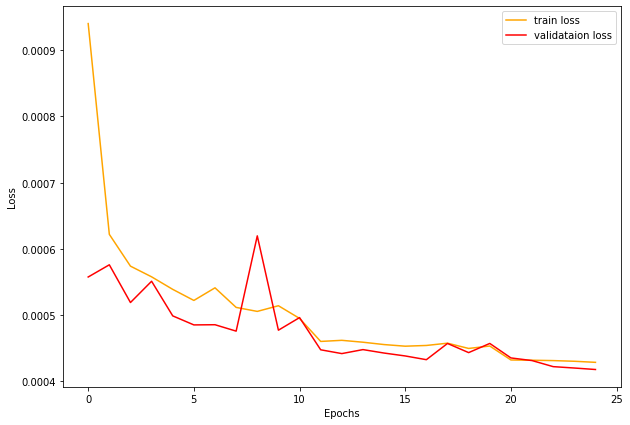

In [42]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/loss.png')
plt.show()

In [75]:
PATH = "/content/model8.pth"
model = DeblurCNN().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [85]:
PATH = "/content/model9.pth"
model = SRCNN().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [86]:
test = os.listdir('/content/data/test/blur')
x_test = []
for i in range(len(test)):
    x_test.append(f"/content/data/test/blur/{test[i]}")

test_data = DeblurDataset(x_test, transforms = transform)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [87]:
!rm -rf /content/submission
!mkdir /content/submission

In [88]:
with torch.no_grad():
  for i, data in tqdm(enumerate(testloader), total=int(len(test_data)/testloader.batch_size)):
      blur_image = data
      blur_image = blur_image.to(device)
      optimizer.zero_grad()
      outputs = model(blur_image)
      save_decoded_image(outputs.cpu().data, name=f"/content/submission/{test[i]}")

100%|██████████| 3000/3000 [02:00<00:00, 24.85it/s]


In [ ]:
!rm -rf original
!mkdir original
!cp -r /content/submission/* original/

In [ ]:
%aicrowd notebook submit -c face-de-blurring -a original --no-verify